In [1]:
import os, sys
import glob
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import wrf
import datetime
import re

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates
import matplotlib.patches as mpatches

# plot styles/formatting
import seaborn as sns

# import personal modules
# Path to modules
sys.path.append('../modules')

# # Import my modules
from wrf_funcs_preprocess import select_single_coord_WRF
# from ar_funcs import get_ar_days, duration_stats
# from timeseries import select_months_ds
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, subtract_days_from_date, add_days_to_date

In [2]:
# Set up paths
server= 'great'
if server == 'great':
    path_to_data = '/home/sbarc/students/nash/data/'
else:
    path_to_data = '/work2/08540/dlnash/frontera/data/'                                      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## Get lines and points for mesoscale analysis

# hlat, hlon, tlat, tlon
Line1 = [39.5, 71., 32.25, 81.]
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate parallel lines
Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

## calculate perpindicular cross section lines
newx_lst = [74.5, 76., 76.25, 78.5]
newx_lst = [74.25, 76.25]
newline = []
ptlst = []
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
    newline.append(line)
    # get intersecting point for each newline and Line3
    pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
    ptlst.append(pt)

In [4]:
## test landslide points
fname = path_to_data + 'CH2_generated_data/Global_Landslide_Catalog_Export.csv' #TODO check this - is it the raw downloaded data?
landslide = pd.read_csv(fname)

# Select lat/lon grid
lonmin = 65
lonmax = 100
latmin = 20
latmax = 42

## Select Landslides within Southern Asia region
idx = (landslide.latitude >= latmin) & (landslide.latitude <= latmax) & (landslide.longitude >= lonmin) & (landslide.longitude <= lonmax)
landslide = landslide.loc[idx]
# set event time as index
landslide = landslide.set_index(pd.to_datetime(landslide.event_date))
# landslide.index = landslide.index.normalize()

# select only landslide dates that are between december and may
idx = (landslide.index.month >= 12) | (landslide.index.month <= 2)
landslide = landslide[idx]

# rename and reindex
landslide = landslide.rename(columns={"latitude": "lat", "longitude": "lon", "event_date": "event_time"})
landslide = landslide.reset_index()

# round event time to the nearest 6 hours
landslide['time'] = landslide['event_date'].dt.round('6H')
landslide = landslide.set_index(pd.to_datetime(landslide.time))

# select only landslide dates that are between december and may
idx = (landslide.index.month >= 12) | (landslide.index.month <= 2)
landslide = landslide[idx]

idx = (landslide.index >= '2010-02-05 00:00') & (landslide.index < '2010-02-10 00:00')
landslide = landslide[idx]
landslide_lats = landslide.lat.values
landslide_lons = landslide.lon.values
landslide_time = landslide.event_time.values
print(len(landslide_lats))

6


In [5]:
landslide

,event_date,source_name,source_link,event_id,event_time,event_time,event_title,event_description,location_description,location_accuracy,...,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,lon,lat,time
time,,,,,,,,,,,,,,,,,,,,,
2010-02-08 18:00:00,2010-02-08 18:00:00,ptinews,http://www.ptinews.com/news/508380_One-killed-...,1487,02/08/2010 06:00:00 PM,NaN,"Narundi area of Uri, Jammu and Kashmir",One person was killed and six others were inju...,"Narundi area of Uri, Jammu and Kashmir",10km,...,Kashmir,6755.0,Uri,2.33067,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,74.0225,34.0876,2010-02-08 18:00:00
2010-02-08 00:00:00,2010-02-08 00:00:00,monstersandcritics,http://www.monstersandcritics.com/news/southas...,1488,02/08/2010 12:00:00 AM,NaN,Ranjata neighborhood,A landslide struck a house in the Ranjata neig...,Ranjata neighborhood,unknown,...,Azad Kashmir,0.0,Bāgh,3.41667,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,73.7526,34.0049,2010-02-08 00:00:00
2010-02-09 00:00:00,2010-02-09 00:00:00,Geo Television Network,http://www.geo.tv/2-9-2010/58906.htm,1494,02/09/2010 12:00:00 AM,NaN,"Kohala area (?), Muzaffarabad",Dozens of houses were demolished and a boy die...,"Kohala area (?), Muzaffarabad",25km,...,Punjab,25247.0,Murree,22.84466,09/15/2014 04:45:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,73.4942,34.0952,2010-02-09 00:00:00
2010-02-06 00:00:00,2010-02-06 00:00:00,kashmirobserver,http://www.kashmirobserver.net/index.php?optio...,1475,02/06/2010 12:00:00 AM,NaN,"Srinagar-Jammu highway near Asar, Doda and Kis...",With bad weather hampering road-clearing opera...,"Srinagar-Jammu highway near Asar, Doda and Kis...",25km,...,Kashmir,20553.0,Kishtwār,17.36463,09/15/2014 06:55:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,75.8011,33.1595,2010-02-06 00:00:00
2010-02-08 00:00:00,2010-02-08 00:00:00,dailytimes,http://www.dailytimes.com.pk/default.asp?page=...,1489,02/08/2010 12:00:00 AM,NaN,"Shangla area of Bazaarkot, Skardu, Muzafarabad...",At least six people were killed in Shangla are...,"Shangla area of Bazaarkot, Skardu, Muzafarabad...",50km,...,Khyber Pakhtunkhwa,0.0,Alpūrai,5.91603,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,72.6625,34.8733,2010-02-08 00:00:00
2010-02-09 06:00:00,2010-02-09 08:00:00,monstersandcritics,http://www.monstersandcritics.com/news/southas...,1493,02/09/2010 08:00:00 AM,NaN,"Khanpur town, located 50 kilometers from the c...",The casualties occurred from collapse of house...,"Khanpur town, located 50 kilometers from the c...",50km,...,Islāmābād,601600.0,Islamabad,14.12512,09/11/2014 07:51:00 PM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,72.9394,33.8147,2010-02-09 06:00:00


In [11]:
idxlst = [0, 1, 2, 3, 4, 5]
for i, idx in enumerate(idxlst):
    print(landslide.iloc[idx].lat, landslide.iloc[idx].lon)
    print(landslide.iloc[idx].event_description)
    print(' ')

34.0876 74.0225
One person was killed and six others were injured when five houses were damaged in landslides in Uri sector of north Kashmir's Baramulla district, officials said today. Mohammad Yousuf Gojjar was killed when his house collapsed due to the landslide at Narundi area of Uri, 100 kms from here, last evening, Sub-District Magistrate Uri Manzoor Ahmad Qadri said. Five members of his family were injured in the incident. In another incident of landslide, Ghulam Mohammad Ahangar, a teacher, was injured at Garkote-Uri and hospitalised, he said. Four residential houses were damaged by landslides in the sector.
 
34.0049 73.7526
A landslide struck a house in the Ranjata neighbourhood Monday, killing a woman and her infant son. 
 
34.0952 73.4942
Dozens of houses were demolished and a boy died as incessant rains and landslides continued to devastated several areas of Muzaffarabad. The fast-flowing floodwater is passing through Kohala area, which is likely to fall into Mangla Lake an

## Get time series of IVT, precip (snow/rain), and freezing level

In [12]:
arname = ['jan1989', 'feb2010']
rain_lst = []
freeze_lst = []
ivt_lst = []
zerodeg_lst = []
idx_lst = [1, 2] # both of these have freezing level for both events/locations but no frozen precip
idx_lst = [3, 4] # no rainfall at location 3, no frozen precip at location 4
idx_lst = [0, 4] # these are the most interesting time series from all 8 landslide locations (in order of longitude)
# idx_lst = [4, 5]
landslide_dates = []
for i, idx in enumerate(idx_lst):
    landslide_dates.append(landslide_time[idx][0]) # time of reported landslide
print(landslide_dates)

for j, ar in enumerate(arname):
    
    # import configuration file for case study choice
    yaml_doc = '../data/config_files/ar_casestudy.yml'
    config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
    ar_dict = config[ar]
    wrf_filenames = ar_dict['wrf_files']
    start_date = ar_dict['start_date']
    end_date = add_days_to_date(ar_dict['end_date'], 1)
    print(start_date, end_date)
    year = ar_dict['year']

    dates = pd.date_range(start_date, end_date, freq='3H')
    
    ## Now get WRF 2D data
    domain = ['d02', 'd02', 'd01', 'd01']
    varname_lst = ['prec', 'sr', 'ivt', 'zerodegisotherm']
    res_lst = ['3hr', '3hr', '3hr', '3hr']

    ## loop through each ds
    ds_lst1 = []
    for i, (dom, varname, res) in enumerate(zip(domain, varname_lst, res_lst)):
        if server == 'great':
            data_path = path_to_data + 'wrf_hasia/'
        else:
            data_path = path_to_data + 'wrf_preprocessed_data/wrf_6km/'

        if res == 'daily':
            filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
        else: 
            filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)

        fname = data_path + filename_pattern
        print(fname)
        ds = xr.open_dataset(fname)

        # subset to just ar days
        ds = ds.sel(time = slice(start_date, end_date))

        if varname == 'ivt':
            ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
        if varname == 'geopotential':
            ds = ds.sel(lev=250.)
        # if varname == 'prec':
        #     # Calculate precipitation rate
        #     ds = ds.shift(time=-1) - ds # if in xarray

        ds_lst1.append(ds)
    
    
    ## select the data at the point location
    rain_rte = []
    freeze = []
    ivt = []
    zerodeg = []
    for i, idx in enumerate(idx_lst):
        xs = landslide_lons[idx]
        ys = landslide_lats[idx]
        # Calculate precipitation rate
        rain = ds_lst1[0].sel(lat=ys, lon=xs, method='nearest')
        rrate = rain.shift(time=-1) - rain # if in xarray
        rain_rte.append(rrate)
        # get fraction of frozen precipitation
        freeze.append(ds_lst1[1].sel(lat=ys, lon=xs, method='nearest'))
        # get IVT
        ivt.append(ds_lst1[2].sel(lat=ys, lon=xs, method='nearest'))
        # get freezing level
        zerodeg.append(ds_lst1[3].sel(lat=ys, lon=xs, method='nearest'))
    rain_lst.append(rain_rte)
    freeze_lst.append(freeze)
    ivt_lst.append(ivt)
    zerodeg_lst.append(zerodeg)
   

['02/08/2010 06:00:00 PM', '02/08/2010 12:00:00 AM']
1989-01-03 1989-01-07
/home/sbarc/students/nash/data/wrf_hasia/d02/prec/3hr/tmp_1989.nc
/home/sbarc/students/nash/data/wrf_hasia/d02/sr/3hr/tmp_1989.nc
/home/sbarc/students/nash/data/wrf_hasia/d01/ivt/3hr/tmp_1989.nc
/home/sbarc/students/nash/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_1989.nc
2010-02-05 2010-02-09
/home/sbarc/students/nash/data/wrf_hasia/d02/prec/3hr/tmp_2010.nc
/home/sbarc/students/nash/data/wrf_hasia/d02/sr/3hr/tmp_2010.nc
/home/sbarc/students/nash/data/wrf_hasia/d01/ivt/3hr/tmp_2010.nc
/home/sbarc/students/nash/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_2010.nc


In [13]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})
# sns.set_style("whitegrid")

# to do: set this to the point lat/lon 
row_lbl = []
for i, idx in enumerate(idx_lst):
    xs = landslide_lons[idx]
    ys = landslide_lats[idx]
    print(xs, ys)
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}E".format(ys, xs)
    print(lbl)
    row_lbl.append(lbl)

print(row_lbl)

### Get x-tick and x-labels for both cases
x1 = rain_lst[0][0].time.values
x2 = rain_lst[1][0].time.values

x_lst = [x1, x2]
xlbl_lst = []
xtick_lst = []
for i, x in enumerate(x_lst):
    x_lbl = []
    xtick_lst.append(x)
    for j in range(len(x)):
        t = pd.to_datetime(str(x[j]))
        x_lbl.append(t.strftime('%d-%H'))
    xlbl_lst.append(x_lbl)
    
# point location for (a) (b) (c) label annotation
xpt = 0.02
ypt = 0.95
ypt2 = 0.975


74.0225 34.0876
34.09°N, 74.02°E
72.6625 34.8733
34.87°N, 72.66°E
['34.09°N, 74.02°E', '34.87°N, 72.66°E']


In [14]:
## get the height of the two points
## get d02 terrain for synoptic plots
fname = ar_dict['wrf_files'][0]
wrfin = nc.Dataset(fname)
elev = []
for i, idx in enumerate(idx_lst):
    xs = landslide_lons[idx]
    ys = landslide_lats[idx]
    print(xs, ys)
    
    x_y = wrf.ll_to_xy(wrfin, ys, xs, timeidx=0, squeeze=True, meta=True, stagger=None, as_int=True)
    x = x_y.values[0] # index of lon value
    y = x_y.values[1] # index of lat value
    
    terrain = wrf.getvar(wrfin, 'ter', timeidx=0)[y, x] # get terrain height at specified coord
    elev.append(terrain.values/1000.)
print(elev)

74.0225 34.0876
72.6625 34.8733
[1.932694580078125, 1.9618387451171875]


Total precip: 149.7262
Total snow: 90.79446
Total rain: 58.93174
Total precip: 212.5658
Total snow: 85.43258
Total rain: 127.13322


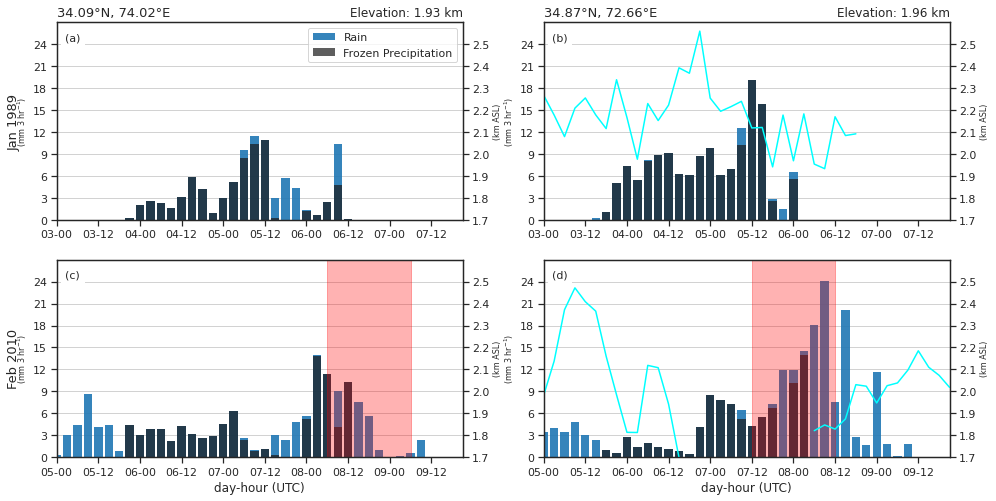

In [22]:
fname = path_to_figs + 'wvf_time_series.png'
nrows = 2 # number of cases
ncols = 2 # number of "station" locations

bar_width = 0.1

# Create figure
fig = plt.figure(figsize=(16, 8))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1, 1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

##########################
### Plot Jan 1989 case ###
##########################
ttl = ['(a)', '(b)']
## precipitation time series
for k, data in enumerate(rain_lst[0]):
    ax = fig.add_subplot(gs[0, k])
    # WRF Precip
    x = data.prec.time.values
    y = data.prec.values
    # print(np.nanmin(y), np.nanmax(y))
    # ax.plot(x, y, color='tab:blue')
    rain = ax.bar(x=x, height=y, width=bar_width, color='tab:blue', alpha=0.9, align='center', label="Rain")

    # WRF SNOW
    snow_vals = y*freeze_lst[0][k].sr.values
    # ax.plot(x, y, color='k')
    snow = ax.bar(x=x, height=snow_vals, width=bar_width, color='k', alpha=0.7, align='center', label="Frozen Precipitation")
    
    # some plot parameters to make it look nice
    ax.set_ylim(0, 27)
    ax.set_yticks(np.arange(0, 27, 3))
    ax.set_xlim(x.min(), x.max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.get_xaxis().set_ticks([])
    
    plt.grid(color = 'grey', axis='y', linestyle = '-', linewidth = 0.5, alpha=0.7)
    
    ax.set_ylabel('(mm 3 hr$^{-1}$)', fontsize=8)
    # y_dates = ys.strftime('%m-%d %H').sort_values().unique()
    # ax.set_yticklabels(labels=y_dates, rotation=0)

    
    # subtitles
    ax.set_title(row_lbl[k], loc='left',fontsize=13)
    # loc_hgt = ds_lst[k].HGT.values.max()/1000.0 # height of gridcell amsl
    # ax.set_title('{:.2f} km'.format(loc_hgt), loc='right',fontsize=13)
    # ax.set_title('{0} km'.format(loc_hgt[k]), loc='right',fontsize=13)
    plt.title('Elevation: {:.2f} km'.format(elev[k]), fontsize=12, loc='right')

    # add red transparent box to the times where landslide was to reported to 24 hr prior
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101, alpha=1.)
    
    if k == 0:
        # Row labels
        ax.text(-0.09, 0.5, 'Jan 1989', va='bottom', ha='center', 
                rotation='vertical', rotation_mode='anchor', fontsize=13, 
                transform=ax.transAxes)
        
        # legend
        ax.legend(loc="upper right")
        
    ## add twin axis for freezing level
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    freeze = ax2.plot(x, zerodeg_lst[1][k].z.values/1000., color='cyan', label="Freezing Level")
    ax2.set_ylim(1.7, 2.6)
    ax2.set_yticks(np.arange(1.7, 2.6, .1))
    ax2.set_ylabel('(km ASL)', fontsize=8)
    
    ## x-axis format dates/ticks
    x_ticks = xtick_lst[0]
    x_labels = xlbl_lst[0]
    ax2.set_xticks(x_ticks[::4]) # set the labels every 12 hours
    ax2.set_xticklabels(x_labels[::4], fontsize=10)
    ax2.set_xlim(x1.min(), x1.max())
    # add x-axis label to this bottom row
    ax2.set_xlabel('day-hour (UTC)')
        
##########################
### Plot Feb 2010 case ###
##########################

## precipitation time series
ttl = ['(c)', '(d)']
for k, data in enumerate(rain_lst[1]):
    times = data.time.values
    ax = fig.add_subplot(gs[1, k])
    # WRF Precip
    x = data.prec.time.values
    y = data.prec.values
    # print(np.nanmin(y), np.nanmax(y))
    # ax.plot(x, y, color='tab:blue')
    ax.bar(x=x, height=y, width=bar_width, color='tab:blue', alpha=0.9, align='center')

    # WRF SNOW
    snow = y*freeze_lst[0][k].sr.values
    # ax.plot(x, y, color='k')
    ax.bar(x=x, height=snow, width=bar_width, color='k', alpha=0.7, align='center')
    
    print('Total precip:', np.nansum(y))
    print('Total snow:', np.nansum(snow))
    print('Total rain:', np.nansum(y)-np.nansum(snow))
    
    # Create rectangle x coordinates
    startTime = pd.to_datetime(landslide_dates[k])
    endTime = startTime + datetime.timedelta(hours = 12)
    startTime = startTime - datetime.timedelta(hours = 12)

    # convert to matplotlib date representation
    start = mdates.date2num(startTime)
    end = mdates.date2num(endTime)
    width = end - start

    # Plot rectangle
    rect = mpatches.Rectangle((start, 0), width, 27, color='red', alpha=0.3)
    ax.add_patch(rect)
    
    # some plot parameters to make it look nice
    ax.set_ylim(0, 27)
    ax.set_yticks(np.arange(0, 27, 3))
    ax.set_xlim(x.min(), x.max())
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)
    # ax.spines['bottom'].set_visible(False)
    # ax.get_xaxis().set_ticks([])
    # ax.get_yaxis().set_ticks([])
    ax.set_ylabel('(mm 3 hr$^{-1}$)', fontsize=8)
    
    plt.grid(color = 'grey', axis='y', linestyle = '-', linewidth = 0.5, alpha=0.7)
        
    # add text title
    ax.text(xpt, ypt, ttl[k], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101, alpha=1.)

    if k == 0:
        # Row labels
        ax.text(-0.09, 0.5, 'Feb 2010', va='bottom', ha='center', 
                rotation='vertical', rotation_mode='anchor', fontsize=13, 
                transform=ax.transAxes)
        
    ## add twin axis for freezing level
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    freeze = ax2.plot(x, zerodeg_lst[0][k].z.values/1000., color='cyan', label="Freezing Level")
    ax2.set_ylim(1.7, 2.6)
    ax2.set_yticks(np.arange(1.7, 2.6, .1))
    ax2.set_ylabel('(km ASL)', fontsize=8)
    
    ## x-axis format dates/ticks
    x_ticks = xtick_lst[1]
    x_labels = xlbl_lst[1]
    ax2.set_xticks(x_ticks[::4]) # set the labels every 12 hours
    ax2.set_xticklabels(x_labels[::4], fontsize=10)
    ax2.set_xlim(x2.min(), x2.max())
    # add x-axis label to this bottom row
    ax.set_xlabel('day-hour (UTC)')

## Save figure
plt.savefig(fname, dpi=300, bbox_inches='tight')

plt.show()

## Vertical profiles of WV Flux

In [22]:
fname_lst = ['35.18N_72.82E', '33.73N_74.82E', '42.85N_71.38E', '28.58N_77.20E']
fname_lst = ['35.18N_72.82E', '33.73N_74.82E'] ## get just these two points
fname_lst = ['34.87N_72.66E', '34.09N_74.02E'] # the landslide points from above
ds_lst1 = []
ds_lst2 = []
ds_lst3 = []
hgt = []
for i, fname in enumerate(fname_lst):
    ## load wvf climatology data
    fname = path_to_data + 'wrf_hasia/d02/wvflux_{0}.nc'.format(fname)
    ds = xr.open_dataset(fname, engine='netcdf4')
    
    ## convert pressure to hPa
    ds = ds.assign(pressure=lambda ds: ds.pressure/100.)
    
    blw_avg = ds.sel(Time='1989-01-05 12')
    abv_avg = ds.sel(Time='2010-02-08 06')
    ## interpolate data to pressure levels
    # Want the wv flux at pressure levels (hPa)
    levels = np.asarray([800., 750., 725., 700., 650., 600., 550., 500., 450., 400., 350., 300.,250.])

    ## Get the climatological values at specified pressure levels
    clim_vals = wrf.interp1d(ds.wvf, ds.pressure, levels)
    clim_vals = clim_vals.where((clim_vals < 1))
    
    # elevation values
    hgt.append(ds.HGT.values[0])
    
    ds_lst1.append(clim_vals) # clim
    ds_lst2.append(blw_avg) # below avg event
    ds_lst3.append(abv_avg) # above avg event
    

# to do: set this to the point lat/lon 
row_lbl = []
for i,  fname in enumerate(fname_lst):
    ## get lat and lon values from fname
    strp_fname = re.findall(r"[-+]?(?:\d*\.*\d+)", fname)
    ys = float(strp_fname[0])
    xs = float(strp_fname[1])
    lbl = u"{:.2f}\N{DEGREE SIGN}N, {:.2f}\N{DEGREE SIGN}E".format(ys, xs)
    print(lbl)
    row_lbl.append(lbl)

34.87°N, 72.66°E
34.09°N, 74.02°E


### Plot WVF average over all AR days and Event WVF

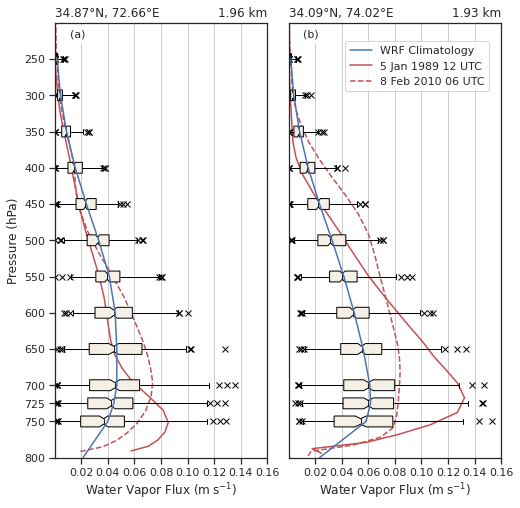

In [36]:
fname = path_to_figs + 'wvf_climatology.png'
nrows = 1 # number of cases
ncols = 2 # number of "station" locations

bar_width = 0.1

# Create figure
fig = plt.figure(figsize=(8, 8))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[2], width_ratios = [1, 1], wspace=0.1, hspace=0.1)
## use gs[rows index, columns index] to access grids

####################
## VERTICAL PLOTS ##
####################
ttl = ['(a)', '(b)']
ypt2 = ypt+0.035
for i, (ds, ds1, ds2) in enumerate(zip(ds_lst1, ds_lst2, ds_lst3)):
    ax = fig.add_subplot(gs[0, i])
    data = ds.mean('Time').values
    data_blw = ds1.wvf.values
    data_abv = ds2.wvf.values
    
    x_levels = np.arange(0.02, 0.18, 0.02)

    event_jan = ax.plot(data_blw, ds1.pressure.values, 'r-', label='5 Jan 1989 12 UTC')
    event_feb = ax.plot(data_abv, ds2.pressure.values, 'r--', label='8 Feb 2010 06 UTC')

    # ax.boxplot(ds.values, vert=False, widths=15.0, positions=ds.z.values)
    bplot = ax.boxplot(ds.values, vert=False, widths=15.0, positions=ds.z.values,
                       patch_artist=True,  # fill with color
                       notch=True, showcaps=True,
                       flierprops={"marker": "x"},
                       medianprops={"color": "k"},
                       # meanline=True, showmeans=True,
                       # meanprops={'c':'blue', 'lw':1},
                       whis=[1, 99])
    
    clim = ax.plot(data, ds.z.values, 'b-', label='WRF Climatology', zorder=101)

    # fill boxes with colors
    color = '#F5F0E6'
    for patch in bplot['boxes']:
        patch.set_facecolor(color)

    # some grid/axes label stuff
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    plt.gca().invert_yaxis()
    ax.set_ylim([800, 200])
        
    ax.set_xlim([0,0.16])
    ax.set_xticks(x_levels)
    # ax.set_yticks(y_levels)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_ylabel('Pressure (hPa)', fontsize=12)
    ax.set_xlabel('Water Vapor Flux ($\mathrm{m \: s^{-1}}$)', fontsize=12)
    ax.grid(linestyle='-')
    
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel('', fontsize=12)
    
    # add text title
    ax.text(xpt+0.05, ypt2, ttl[i], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101, alpha=1.)
    # subtitles
    loc_hgt = float(hgt[i])/1000.0 # height of gridcell amsl
    ax.set_title('{:.2f} km'.format(loc_hgt), loc='right',fontsize=12)
    ax.set_title(row_lbl[i], loc='left',fontsize=12) # lat/lon location
    
    if i == 1:
        ## add legend
        lns = clim+event_jan+event_feb
        labs = [l.get_label() for l in lns]
        plt.legend(lns, labs, loc='upper right', bbox_to_anchor=(0.97, 0.97))



## Save figure
plt.savefig(fname, dpi=300, bbox_inches='tight')

plt.show()